In [27]:
import warnings
warnings.filterwarnings("ignore")
import os
import gc
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
import lightgbm as lgb
import xgboost
from sklearn.externals import joblib
import csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('../data/train.csv')

In [4]:
train.head()

ID      target  48df886f9  0deb4b6a8  34b15f335  a8cb14b00  \
0  000d6aaf2  38000000.0        0.0          0        0.0          0   
1  000fbd867    600000.0        0.0          0        0.0          0   
2  0027d6b71  10000000.0        0.0          0        0.0          0   
3  0028cbf45   2000000.0        0.0          0        0.0          0   
4  002a68644  14400000.0        0.0          0        0.0          0   

   2f0771a37  30347e683  d08d1fbe3  6ee66e115    ...      3ecc09859  \
0          0          0          0          0    ...            0.0   
1          0          0          0          0    ...            0.0   
2          0          0          0          0    ...            0.0   
3          0          0          0          0    ...            0.0   
4          0          0          0          0    ...            0.0   

   9281abeea  8675bec0b  3a13ed79a  f677d4d13  71b203550  137efaa80  \
0        0.0        0.0          0          0          0          0   
1        0.0        0.0          0          0          0          0   
2        0.0        0.0          0          0          0          0   
3        0.0        0.0          0          0          0          0   
4        0.0        0.0          0          0          0          0   

   fb36b89d9  7e293fbaf  9fc776466  
0          0          0          0  
1          0          0          0  
2          0          0          0  
3          0          0          0  
4          0          0          0  

[5 rows x 4993 columns]

In [5]:
def rmsle(y, pred):
    y = np.expm1(y)
    pred = np.expm1(pred)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(pred), 2)))

In [6]:
def rmsle(y, pred):
    y = np.expm1(y)
    pred = np.expm1(pred)
    return np.sqrt((1/len(y))*np.sum((np.log1p(pred)-np.log1p(y))**2))

In [7]:
RANDOM_STATE = 1992
K = 5
kf = KFold(n_splits = K, random_state = RANDOM_STATE, shuffle = True)

In [12]:
X = np.array(train.drop(['target','ID'], axis = 1))
y = np.array(np.log1p(train['target']))

In [8]:
X = train.loc[:,train.columns != 'ID']
X = X.loc[:,X.columns != 'target']
y = np.log1p(train.loc[:, 'target'])

Regression with Keras

In [19]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4991, input_dim=4991, kernel_initializer='normal', activation='relu'))
    model.add(Dense(512, kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
    return model

In [23]:
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=10, batch_size=1, verbose=1)

In [24]:
estimator.fit(X,y)

Epoch 1/10
1057/4459 [======>.......................] - ETA: 11:31 - loss: 7.5477

KeyboardInterrupt: 

In [16]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold, n_jobs=1)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

KeyboardInterrupt: 

RandomForestRegressor

In [82]:
scores_list = list()
n = 1
model = RandomForestRegressor(n_jobs = 4, random_state = RANDOM_STATE)
for train_index, test_index in kf.split(X):
    print('fold = {}'.format(n))
    train_X, valid_X = X.iloc[train_index,:], X.iloc[test_index,:]
    train_y, valid_y = y[train_index], y[test_index]
    model.fit(train_X, train_y)
    preds = model.predict(valid_X)
    score = rmsle(valid_y, preds)
    print('score = {}'.format(score))
    scores_list.append(score)
    n += 1
    
print('mean score: {}'.format(round(np.sum(scores_list)/K,2)))

fold = 1
score = 1.4734569876508705
fold = 2
score = 1.4981705133355077
fold = 3
score = 1.456749257147706
fold = 4
score = 1.5206348782242967
fold = 5
score = 1.5371396629042402
mean score: 1.5


Lasso

In [50]:
scores_list = list()
n = 1
model = Lasso(alpha = 10, random_state = RANDOM_STATE)
for train_index, test_index in kf.split(X):
    print('fold = {}'.format(n))
    train_X, valid_X = X.iloc[train_index,:], X.iloc[test_index,:]
    train_y, valid_y = y[train_index], y[test_index]
    model.fit(train_X, train_y)
    preds = model.predict(valid_X)
    score = rmsle(valid_y, preds)
    print('score = {}'.format(score))
    scores_list.append(score)
    n += 1
    
print('mean score: {}'.format(round(np.sum(scores_list)/K,2)))

fold = 1
score = inf
fold = 2


KeyboardInterrupt: 

LightGBM

In [26]:
scores_list = list()
n = 1

for train_index, test_index in kf.split(X):
    print('fold = {}'.format(n))
    train_X, valid_X = X.iloc[train_index,:], X.iloc[test_index,:]
    train_y, valid_y = y[train_index], y[test_index]
    
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_eval = lgb.Dataset(valid_X, valid_y, reference=lgb_train)
    params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 200,
    "feature_fraction": 0.50,
    "bagging_fraction": 0.50,
    'bagging_freq': 4,
    "max_depth": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.1,
    #"min_split_gain":0.2,
    "min_child_weight":10,
    }

    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=30,
                    valid_sets=lgb_eval,
    early_stopping_rounds=10)
    
    preds = gbm.predict(valid_X)
    score = rmsle(valid_y, preds)
    print('score = {}'.format(score))
    scores_list.append(score)
    n += 1
    
print('mean score: {}'.format(round(np.sum(scores_list)/K,2)))

fold = 1
[1]	valid_0's rmse: 1.72032
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 1.71622
[3]	valid_0's rmse: 1.71257
[4]	valid_0's rmse: 1.70873
[5]	valid_0's rmse: 1.70498
[6]	valid_0's rmse: 1.70139
[7]	valid_0's rmse: 1.69782
[8]	valid_0's rmse: 1.69384
[9]	valid_0's rmse: 1.69054
[10]	valid_0's rmse: 1.68705
[11]	valid_0's rmse: 1.6837
[12]	valid_0's rmse: 1.68048
[13]	valid_0's rmse: 1.67693
[14]	valid_0's rmse: 1.67313
[15]	valid_0's rmse: 1.6697
[16]	valid_0's rmse: 1.66672
[17]	valid_0's rmse: 1.66334
[18]	valid_0's rmse: 1.65965
[19]	valid_0's rmse: 1.65668
[20]	valid_0's rmse: 1.65368
[21]	valid_0's rmse: 1.65107
[22]	valid_0's rmse: 1.64788
[23]	valid_0's rmse: 1.64493
[24]	valid_0's rmse: 1.641
[25]	valid_0's rmse: 1.63845
[26]	valid_0's rmse: 1.63579
[27]	valid_0's rmse: 1.63251
[28]	valid_0's rmse: 1.63012
[29]	valid_0's rmse: 1.62728
[30]	valid_0's rmse: 1.62477
Did not meet early stopping. Best iteration is:
[30]	valid_0's rmse: 1.6

In [83]:
preds = model.predict(X[:500])

In [132]:
rango = np.arange(0.016, 0.021, 0.0001)

In [133]:
for x in rango:
    preds2 = [i+i*x if i > 15.5 else i for i in preds]
    preds3 = [i-i*x if i < 13.5 else i for i in preds2]
    print(x, rmsle(y[:500], preds2))

0.016 0.8797364943855991
0.0161 0.8797252183341433
0.0162 0.8797145788003643
0.0163 0.8797045758073571
0.016399999999999998 0.8796952093768359
0.016499999999999997 0.8796864795291341
0.016599999999999997 0.879678386283204
0.016699999999999996 0.8796709296566162
0.016799999999999995 0.87966410966556
0.016899999999999995 0.879657926324843
0.016999999999999994 0.8796523796478904
0.017099999999999994 0.8796474696467464
0.017199999999999993 0.8796431963320722
0.017299999999999992 0.8796395597131467
0.017399999999999992 0.8796365597978668
0.01749999999999999 0.8796341965927469
0.01759999999999999 0.8796324701029185
0.01769999999999999 0.8796313803321307
0.01779999999999999 0.8796309272827502
0.01789999999999999 0.8796311109557605
0.017999999999999988 0.8796319313507632
0.018099999999999988 0.8796333884659765
0.018199999999999987 0.8796354822982362
0.018299999999999986 0.8796382128429955
0.018399999999999986 0.8796415800943251
0.018499999999999985 0.8796455840449132
0.018599999999999985 0.879

In [134]:
preds4 = [i-i*0.0178 if i < 13.5 else i for i in preds2]

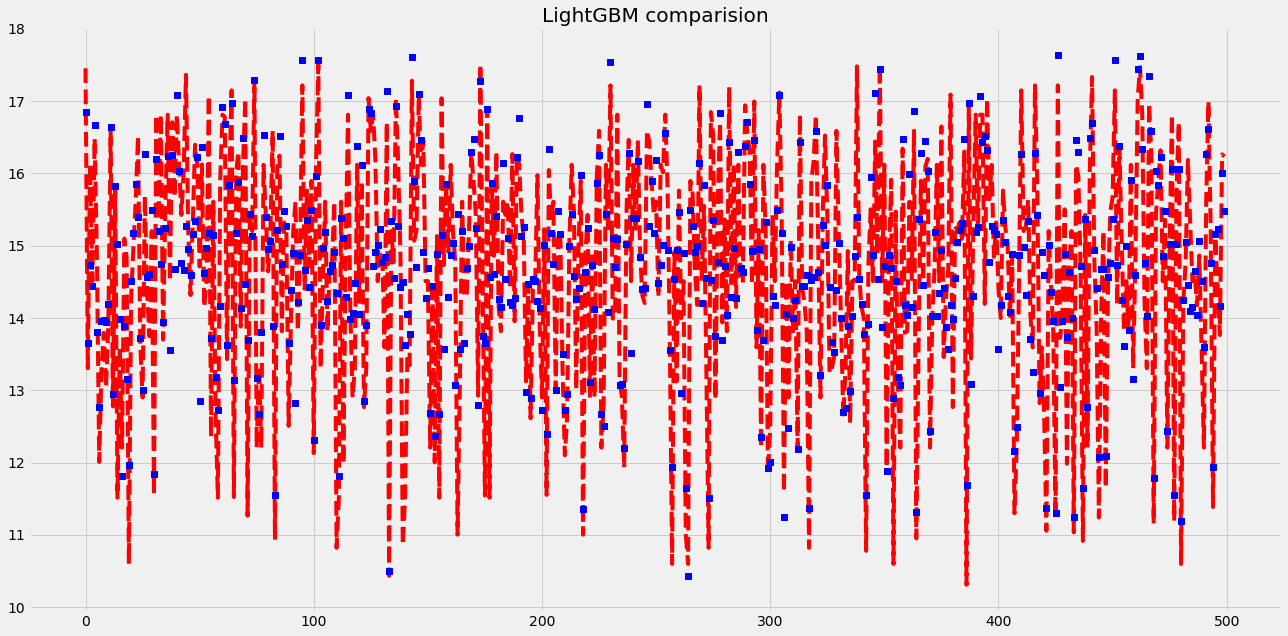

In [135]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,10))
x = np.arange(0, 500, 1)
plt.plot(x, y[:500], 'r--', preds4, 'bs')

plt.gca().set_title("LightGBM comparision")

XGBoost

In [69]:
scores_list = list()
n = 1
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
for train_index, test_index in kf.split(X):
    print('fold = {}'.format(n))
    train_X, valid_X = X[train_index], X[test_index]
    train_y, valid_y = y[train_index], y[test_index]
    xgb.fit(train_X, train_y)
    preds = xgb.predict(valid_X)
    score = rmsle(valid_y, preds)
    print('score = {}'.format(score))
    scores_list.append(score)
    n += 1
    
print('mean score: {}'.format(round(np.sum(scores_list)/K,2)))

fold = 1
score = 0.09687677946432283
fold = 2
score = 0.09897650411169517
fold = 3
score = 0.09904497864816228
fold = 4
score = 0.09912257986387968
fold = 5
score = 0.10079244732605544
mean score: 0.1


STACKING

In [41]:
scores_list = list()
n = 1

xgb_model = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.05, gamma=0, subsample=0.6,
                           colsample_bytree=1, max_depth=7)

lasso = Lasso(alpha = 0.1, random_state = RANDOM_STATE)

rf = RandomForestRegressor(n_jobs = 4, random_state = RANDOM_STATE)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 1,
    'bagging_fraction': 0.6,
    'bagging_freq': 5,
    'verbose': -1
    }

for train_index, test_index in kf.split(X):
    print('fold = {}'.format(n))
    train_X, valid_X = X[train_index], X[test_index]
    train_y, valid_y = y[train_index], y[test_index]
    
    # XGBoost
    print('Training XGBoost model...')
    xgb_model.fit(train_X, train_y)
    preds_xgb = xgb_model.predict(valid_X)
    score_xgb = rmsle(valid_y, preds_xgb)
    print('score XGB = {}'.format(score_xgb))
    
    #LightGBM
    print('Training LightGBM model...')
    lgb_train = lgb.Dataset(train_X, train_y)
    lgb_eval = lgb.Dataset(valid_X, valid_y, reference=lgb_train)
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=30,
                    valid_sets=lgb_eval,
    early_stopping_rounds=10)
    preds_lgb = gbm.predict(valid_X)
    score_lgb = rmsle(valid_y, preds_lgb)
    print('score LGB = {}'.format(score_lgb))
    
    #Lasso
    print('Training Lasso model...')
    lasso.fit(train_X, train_y)
    preds_lasso = lasso.predict(valid_X)
    score_lasso = rmsle(valid_y, preds_lasso)
    print('score Lasso = {}'.format(score_lasso))
    
    #RandomForest
    print('Training RandomForest model...')
    rf.fit(train_X, train_y)
    preds_rf = rf.predict(valid_X)
    score_rf = rmsle(valid_y, preds_rf)
    print('score RF = {}'.format(score_rf))
    
    preds = (preds_xgb*preds_lgb*preds_lasso*preds_rf)**(1/4)
    
    score = rmsle(valid_y, preds)
    scores_list.append(score)
    n += 1
    
print('mean score: {}'.format(round(np.sum(scores_list)/K,2)))

fold = 1
Training XGBoost model...
score XGB = 0.09771178108124753
Training LightGBM model...
[1]	valid_0's l2: 2.91608
Train until valid scores didn't improve in 10 rounds.
[2]	valid_0's l2: 2.85412
[3]	valid_0's l2: 2.79997
[4]	valid_0's l2: 2.7513
[5]	valid_0's l2: 2.70179
[6]	valid_0's l2: 2.65037
[7]	valid_0's l2: 2.60244
[8]	valid_0's l2: 2.55809
[9]	valid_0's l2: 2.52562
[10]	valid_0's l2: 2.49254
[11]	valid_0's l2: 2.46059
[12]	valid_0's l2: 2.43038
[13]	valid_0's l2: 2.4065
[14]	valid_0's l2: 2.38424
[15]	valid_0's l2: 2.36019
[16]	valid_0's l2: 2.33787
[17]	valid_0's l2: 2.3136
[18]	valid_0's l2: 2.2929
[19]	valid_0's l2: 2.27866
[20]	valid_0's l2: 2.26342
[21]	valid_0's l2: 2.25248
[22]	valid_0's l2: 2.23858
[23]	valid_0's l2: 2.22664
[24]	valid_0's l2: 2.21709
[25]	valid_0's l2: 2.20629
[26]	valid_0's l2: 2.19334
[27]	valid_0's l2: 2.18456
[28]	valid_0's l2: 2.17564
[29]	valid_0's l2: 2.16557
[30]	valid_0's l2: 2.15261
score LGB = 0.09796925495911162
Training Lasso model...

In [74]:
round(np.sum(scores_list)/K,4)

0.0997

Predictions of Models stacking

In [8]:
def stack_predict(X_test):
    test_preds_xgb = xgb_model.predict(X_test)
    test_preds_gbm = gbm.predict(X_test)
    test_preds_lasso = lasso.predict(X_test)
    test_preds_xgb = rf.predict(X_test)
    
    return np.expm1((test_preds_xgb*test_preds_gbm*test_preds_lasso*test_preds_xgb)**(1/4))

In [9]:
def stack_predict_2(X_test):
    test_preds_xgb = xgb_model.predict(X_test)
    test_preds_gbm = gbm.predict(X_test)
    test_preds_lasso = lasso.predict(X_test)
    test_preds_xgb = rf.predict(X_test)
    
    return np.expm1((test_preds_xgb+test_preds_gbm+test_preds_lasso+test_preds_xgb)/4)

Saving Models

In [10]:
def save_model(model, name):
    if not os.path.exists('models/'):
        os.makedirs('models/')
    joblib.dump(model, 'models/{0}.pkl'.format(name))

In [45]:
save_model(lasso, 'lasso')
save_model(gbm, 'lightgbm')
save_model(rf, 'randomforest')
save_model(xgb_model, 'xgboost')

In [11]:
lasso = joblib.load('models/lasso.pkl') 
gbm = joblib.load('models/lightgbm.pkl') 
rf = joblib.load('models/randomforest.pkl') 
xgb_model = joblib.load('models/xgboost.pkl') 

In [14]:
lasso.fit(X, y)
rf.fit(X, y)
xgb_model.fit(X, y)

NameError: name 'params' is not defined

In [18]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "learning_rate": 0.01,
    "num_leaves": 200,
    "feature_fraction": 0.50,
    "bagging_fraction": 0.50,
    'bagging_freq': 4,
    "max_depth": -1,
    "reg_alpha": 0.3,
    "reg_lambda": 0.1,
    #"min_split_gain":0.2,
    "min_child_weight":10,
}

lgb_train = lgb.Dataset(X, y)
gbm = lgb.train(lgbm_params,
                lgb_train,
                num_boost_round=30)

In [19]:
preds_test = list()
preds_test += stack_predict(X[:10]).tolist()
preds_test += stack_predict(X[10:20]).tolist()

In [20]:
preds_test

[6345990.75704731,
 1119124.1343001341,
 3686354.825470887,
 1766782.8797762825,
 3817699.604718766,
 2101616.641633009,
 376826.15027689934,
 2143474.7288047536,
 1738838.5910107351,
 1353520.3048214323,
 1839467.0435499107,
 4993806.019932196,
 833031.8261892154,
 3287418.2180998544,
 766793.9196172775,
 1068313.0446963382,
 590956.4784681009,
 2676023.746294218,
 2155334.31688239,
 653293.5514291452]

Load and predicting TEST data

In [48]:
# 53801 aprox row in test

In [21]:
del train
del X
del y
gc.collect()

466

In [24]:
def predictions(CS = 1e4):
    preds_test = list()
    IDs = list()
    reader = pd.read_table('data/scaled_test.csv', sep=',', chunksize=CS)
    n = 0
    for chunk in reader:
        IDs += chunk['ID'].tolist()
        X_test = chunk.loc[:,chunk.columns != 'ID']
        X_test = np.array(chunk.drop(['target','ID'], axis = 1))
        preds_test += stack_predict(X_test).tolist()
        n += 1
    return preds_test, IDs

In [25]:
preds_test, IDs = predictions()

In [26]:
# preds_test = list()
# IDs = list()
# reader = pd.read_table('data/scaled_test.csv', sep=',', chunksize=1e4)
# n = 0
# for chunk in reader:
# #     print(chunk)
# #     print(len(chunk))
#     np.array(train.drop(['target','ID'], axis = 1))
#     IDs += chunk['ID'].tolist()
#     X_test = chunk.loc[:,chunk.columns != 'ID']
#     X_test = np.array(chunk.drop(['target','ID'], axis = 1))
#     preds_test += stack_predict(X_test).tolist()
#     n += 1
#     if n == 2:
#         break
# print(preds_test, IDs)

In [27]:
len(preds_test), len(IDs)

(49342, 49342)

In [28]:
def submit(name, preds_test, IDs):
    if not os.path.exists('submissions/'):
        os.makedirs('submissions/')
    with open('submissions/{}.csv'.format(name), 'w') as f:
        n = 0
        f.write("ID,target\n")
        for _ in range(len(preds_test)):
            f.write("%s,%s\n" % (IDs[n], preds_test[n]))
            n += 1
    f.close()

In [171]:
submit('first', preds_test, IDs)

In [180]:
submit('second', preds_test, IDs)

In [29]:
submit('third', preds_test, IDs)

In [30]:
del preds_test
del IDs
gc.collect()

606